In [29]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import transforms, io
from tqdm import tqdm
from matplotlib import pyplot as plt

from room_rate.data.dataset import RatedImageDataset
from room_rate.models import RaterResNet

In [17]:
def im_norm(im):
    """
    Convert image from 0 to 255 (int) to -1 to 1 (float)
    """
    return (im.float()/128 - 1).float()

#Add in some minimal data augmentation for training, 
#since dataset is limited and we'll want to train multiple epochs
agument = transforms.Compose([
    transforms.RandomAffine([-15,15], translate=(0,.05), scale=(.9,1.1)),
    transforms.RandomHorizontalFlip(),
    im_norm,
])

In [38]:
data_dir = '../data/rated_images_no0/'
train = RatedImageDataset(data_dir + 'train/', transform=augment) #Apply augmentation in training
test = RatedImageDataset(data_dir + 'test/', transform=im_norm) #Not in testing

In [39]:
batch_size = 8
train_loader = DataLoader(train, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

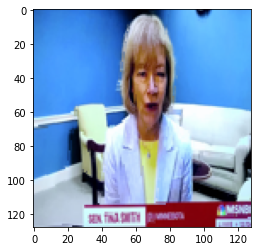

In [48]:
#Show an example agumented image
#Normalization is undone for viewing
plt.imshow((next(iter(train_loader))[0][0].permute(1,2,0))/2 + .5)

In [53]:
net = RaterResNet() #Resnet18 with single output (for rating)

train_losses = []
test_losses = []

In [52]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=3e-4)

In [54]:
# nr = 100

for epoch in range(4):  # loop over the dataset multiple times
    #Train:
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss = running_loss/len(train_loader)
    print('train_loss: ' + str(running_loss))
    train_losses.append(running_loss)
    
    #Test
    running_loss = 0,0
    for images, labels in tqdm(test_loader):
        out = net(images)
        loss = criterion(out.squeeze(), labels.float())
        running_loss += loss.item()
    running_loss = running_loss/len(test_loader)
    test_losses.append(running_loss)
    print('test_loss: ' + str(running_loss))

print('Finished Training')

100%|██████████| 283/283 [06:19<00:00,  1.34s/it]


train_loss: 3.23975446241062


100%|██████████| 94/94 [01:07<00:00,  1.39it/s]


test_loss: 2.2559581844413534


100%|██████████| 283/283 [05:25<00:00,  1.15s/it]


train_loss: 2.2298714595422306


100%|██████████| 94/94 [00:32<00:00,  2.86it/s]


test_loss: 2.184080384513165


100%|██████████| 283/283 [06:01<00:00,  1.28s/it]


train_loss: 2.166659860749969


100%|██████████| 94/94 [00:39<00:00,  2.41it/s]


test_loss: 2.136955405169345


100%|██████████| 283/283 [05:42<00:00,  1.21s/it]


train_loss: 2.085800753360081


100%|██████████| 94/94 [00:42<00:00,  2.23it/s]

test_loss: 2.1232536197342773
Finished Training


Plot losses over epochs

Text(0.5, 0, 'Epoch')

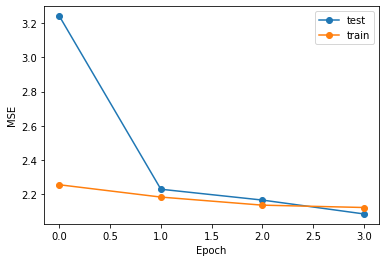

In [72]:
plt.plot(train_losses, 'o-', label='test')
plt.plot(test_losses, 'o-', label='train')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epoch')

Calculate predictions on test set (and save actual test set ratings)

In [65]:
labell = []
resultl = []
for images, labels in tqdm(test_loader):
    out = net(images)
    resultl.append(list(out.detach()))
    labell.append(list(labels))

r = torch.tensor(resultl).flatten()
l = torch.tensor(labell).flatten()

Quick way to view data: scatter plot

/Users/jot/anaconda3/envs/twit/lib/python3.8/site-packages/numpy/ma/core.py:2829: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/jot/anaconda3/envs/twit/lib/python3.8/site-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/jot/anacond

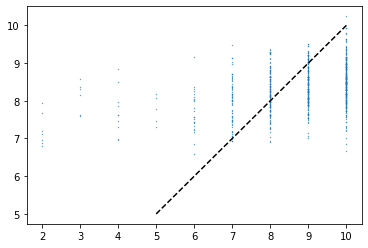

In [59]:
plt.scatter(labell, resultl, s = .1)
plt.plot([5,10], [5, 10], 'k--')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')

Group data by actual rating

In [129]:
rate_range = range(1, 11)
rdict = {val: [] for val in rate_range}

for i,label in enumerate(l):
    rdict[label.item()].append(r[i].item())

So we can get average/std for each actual rating

In [130]:
means = [torch.tensor(rdict[i]).mean() for i in rate_range]
stds = [torch.tensor(rdict[i]).var().sqrt() for i in rate_range]

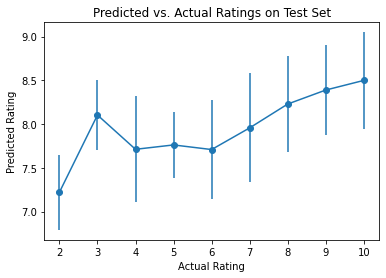

In [134]:
plt.errorbar(rate_range, means, stds, fmt = 'o-')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs. Actual Ratings on Test Set')
plt.savefig('../imgs/Mean_Std_Results_MSELoss.png')
# plt.plot([5,10], [5, 10], 'k--')